# Aperçu
Dans ce devoir, nous explorerons le finetuning de deux modèles distincts:
1. Distillbert pour une tâche de classification de sentiments.
2. Le récent modèle OpenLlama-2-3b pour le transformer en chatbot.


In [ ]:
# Installation des dépendances
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but

In [ ]:
!pip install -q -U datasets bitsandbytes einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install -U fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.9.2 which is incompatible.


# 1. Distillbert pour Classification de Sentiments

**Livrables:**

Explorez 2 méthodes différentes d'ajustement de modèle (nombre d'époques, taux d'apprentissage, weight decay, etc.) pour améliorer les performances de classification. Détaillez la méthodologie suivie pour améliorer les performances du modèle. Une discussion approfondie des approches choisies est attendue (des points seront déduits pour des modifications aléatoires des hyperparamètres du modèle).

Vous devrez inclure dans votre rapport:
- L'exactitude (accuracy)
- La précision
- Le rappel
- Les scores F1
- L'image de votre matrice de confusion sous forme de heatmap

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
import pandas as pd

from datasets import load_dataset, Dataset, DatasetDict

## Ensemble de données

In [ ]:
file_path = "data/IMDB_dataset_clean.csv"

try:
    import google.colab
    from google.colab import drive
    # Monter Google Drive
    drive.mount("/content/drive")

    # Spécifier le chemin du fichier dans Google Drive
    file_path = "/content/drive/My Drive/data/IMDB_dataset_clean.csv"
except:
    file_path = "data/IMDB_dataset_clean.csv"

imdb_df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
X_train, X_test = train_test_split(imdb_df, test_size=0.2, random_state=42)

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(X_train, preserve_index=False),
    "test": Dataset.from_pandas(X_test, preserve_index=False)
    })

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

# Tokenize the training and test sets
train_tokenized = dataset["train"].map(tokenize_function, batched=True)
test_tokenized = dataset["test"].map(tokenize_function, batched=True)

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

In [ ]:
train_tokenized, test_tokenized

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 39665
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 9917
 }))

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Téléchargement du modèle

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    probabilities = pred.predictions[:, 1]  # En assumant les probabilités pour la classe 1

    preds = (probabilities > 0.5).astype(int)  # Threshold à 0.5 pour déterminer la classe

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    acc = accuracy_score(labels, preds)

    return {
        "y_true": labels,
        "y_pred": preds,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "confusion_matrix": cm
    }

## Version 1 - Baseline

### Entraînement

In [ ]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-15-2574cc2db55d>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()

Step,Training Loss
500,0.407600
1000,0.302200
1500,0.276600
2000,0.258800


### Évaluation du modèle

In [ ]:
eval_results = trainer.evaluate()

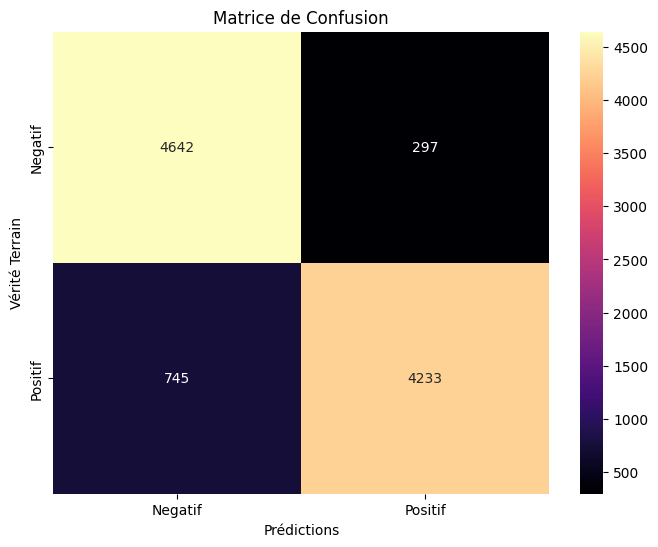

Exactitude (Accuracy): 0.8949
Précision (Precision): 0.9344
Rappel (Recall): 0.8503
F1-Score: 0.8904


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction des métriques
conf_matrix = eval_results["eval_confusion_matrix"]

# Matrice de confusion en heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="magma", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.title("Matrice de Confusion")
plt.show()

# Résumé des métriques
print(f"Exactitude (Accuracy): {eval_results['eval_accuracy']:.4f}")
print(f"Précision (Precision): {eval_results['eval_precision']:.4f}")
print(f"Rappel (Recall): {eval_results['eval_recall']:.4f}")
print(f"F1-Score: {eval_results['eval_f1-score']:.4f}")


## Version 2 - Learning Rate plus grand

### Entraînement

In [ ]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-20-4655e0be8629>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()

Step,Training Loss
500,0.699300
1000,0.693200


### Évaluation du modèle

In [ ]:
eval_results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


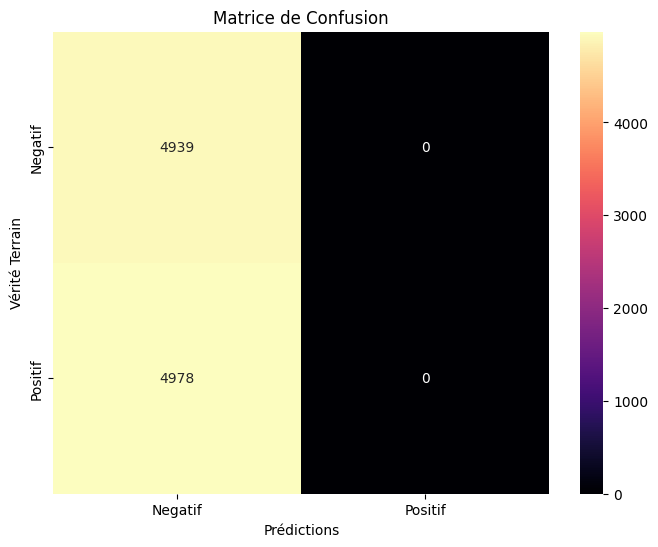

Exactitude (Accuracy): 0.4980
Précision (Precision): 0.0000
Rappel (Recall): 0.0000
F1-Score: 0.0000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction des métriques
conf_matrix = eval_results["eval_confusion_matrix"]

# Matrice de confusion en heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="magma", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.title("Matrice de Confusion")
plt.show()

# Résumé des métriques
print(f"Exactitude (Accuracy): {eval_results['eval_accuracy']:.4f}")
print(f"Précision (Precision): {eval_results['eval_precision']:.4f}")
print(f"Rappel (Recall): {eval_results['eval_recall']:.4f}")
print(f"F1-Score: {eval_results['eval_f1-score']:.4f}")


## Version 3 - Weight decay plus petit

### Entraînement

In [ ]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.005,
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-24-11286f483f18>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()

Step,Training Loss
500,0.693200
1000,0.693200
1500,0.737300
2000,0.693100


### Évaluation du modèle

In [ ]:
eval_results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


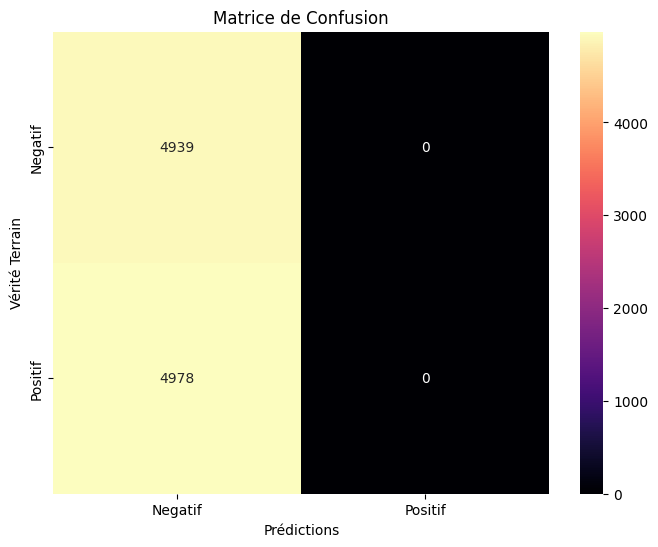

Exactitude (Accuracy): 0.4980
Précision (Precision): 0.0000
Rappel (Recall): 0.0000
F1-Score: 0.0000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction des métriques
conf_matrix = eval_results["eval_confusion_matrix"]

# Matrice de confusion en heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="magma", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.title("Matrice de Confusion")
plt.show()

# Résumé des métriques
print(f"Exactitude (Accuracy): {eval_results['eval_accuracy']:.4f}")
print(f"Précision (Precision): {eval_results['eval_precision']:.4f}")
print(f"Rappel (Recall): {eval_results['eval_recall']:.4f}")
print(f"F1-Score: {eval_results['eval_f1-score']:.4f}")


# 2. Finetune d'OpenLlama-2-3b
Cette section explique comment ajuster finetune le modèle OpenLlama-2-3b sur Google Colab pour le transformer en chatbot.

Nous utiliserons la bibliothèque PEFT de l'écosystème Hugging Face, ainsi que QLoRA pour être plus efficace en termes de mémoire.

**Livrables**

1. Expérimentez avec 3 configurations différentes pour LORA et créez un graphique linéaire avec le paramètre r sur l'axe des x. Incluez une discussion sur les effets de la modification de cet hyperparamètre.

2. Écrivez le code pour ajouter un exemple au jeu de données.

## Ensemble de données

In [ ]:
from datasets import load_dataset

dataset_name = 'gberseth/IFT6758-comments'
dataset = load_dataset(dataset_name, split="train")

In [ ]:
dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 5749
})

In [ ]:
dataset = dataset.map(lambda example: {'text': example['input'] + example['output']})

In [ ]:
dataset

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 5749
})

## Téléchargement du modèle

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

## Setup des arguments

In [ ]:
output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 2
optim = "paged_adamw_32bit"
save_steps = 1
num_train_epochs = 4
logging_steps = 1
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 200
warmup_ratio = 0.03
lr_scheduler_type = "linear"

max_seq_length = 512

lora_alpha = 8
lora_dropout = 0.1

In [ ]:
from transformers import TrainingArguments
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, get_peft_model

training_arguments = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    report_to="none",
    dataset_text_field="text",
    max_seq_length=max_seq_length,
)

## Expérimentation sur différentes valeurs de `r`

In [ ]:
from collections import defaultdict
import time

# Expérimentation avec différents valeurs de r
r_values = [4, 8, 16]
results = defaultdict(list)

for r in r_values:
    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=r,
        bias="none",
        task_type="CAUSAL_LM"
    )
    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
        args=training_arguments,
    )

    for name, module in trainer.model.named_modules():
        if "norm" in name:
            module = module.to(torch.float32)

    start_time = time.time()
    train_result = trainer.train()
    end_time = time.time()
    training_time = end_time - start_time  # Calculate training time

    results["r"].append(r)
    results["loss"].append(train_result.training_loss)
    results["training_time"].append(training_time)  # Store training time


<ipython-input-49-ffd92dddb42f>:21: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.182300
2,3.309300
3,3.153100
4,3.218600
5,3.604800
6,4.005700
7,4.080200
8,3.465800
9,3.475500
10,3.908600


<ipython-input-49-ffd92dddb42f>:21: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.182300
2,3.309300
3,3.153500
4,3.217900
5,3.604100
6,4.006400
7,4.081000
8,3.466600
9,3.474800
10,3.905500


<ipython-input-49-ffd92dddb42f>:21: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.182300
2,3.309300
3,3.152700
4,3.219200
5,3.604500
6,4.006600
7,4.083400
8,3.468700
9,3.473900
10,3.907200


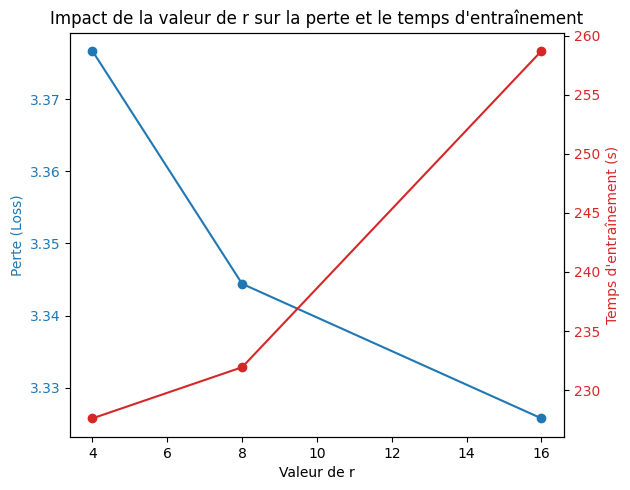

In [ ]:
# Visualisation des performances
fig, ax1 = plt.subplots()

ax1.set_xlabel("Valeur de r")
ax1.set_ylabel("Perte (Loss)", color="tab:blue")
ax1.plot(results["r"], results["loss"], marker="o", color="tab:blue", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()  # Create a second y-axis to plot training time
ax2.set_ylabel("Temps d'entraînement (s)", color="tab:red")
ax2.plot(results["r"], results["training_time"], marker="o", color="tab:red", label="Training Time")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.tight_layout()  # Ensure everything fits
plt.title("Impact de la valeur de r sur la perte et le temps d'entraînement")
plt.show()

## Génération de texte

In [ ]:
text = "Hey, how are you?"
device = "cuda:0"

peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=8,
        bias="none",
        task_type="CAUSAL_LM"
)

### Initiale

#### Préparer le modèle

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

#### Entraîner

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

train_result = trainer.train()

<ipython-input-46-c4b1af3d56a8>:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.182300
2,3.309300
3,3.152900
4,3.218700
5,3.605400
6,4.006600
7,4.082200
8,3.467800
9,3.476000
10,3.907000


#### Générer le texte

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
# Génération avant l'ajout
print("Input:\n", text)

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print("Réponse initiale:\n", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input:
 Hey, how are you?
Réponse initiale:
 Hey, how are you?
I’m a 24 year old girl from the Netherlands. I’m a student of the University of Amsterdam and I’m currently studying International Business. I’m a big fan of fashion and I love to shop. I’


### Ajout de données 1 (non liées à l'input)

In [ ]:
# Ajouter un exemple au jeu de données
nouvel_exemple = {
    "input": "Hi, how can I help you today?",
    "output": "I would like to learn how to play the piano; can you help me?",
}
dataset_new = dataset.add_item({
    "input": nouvel_exemple["input"],
    "output": nouvel_exemple["output"],
    "text": nouvel_exemple["input"] + nouvel_exemple["output"]
})

#### Préparer le modèle

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

#### Ré-entraîner

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_new,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

train_result = trainer.train()

<ipython-input-55-097c001fcfdc>:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/5750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.336000
2,3.412100
3,3.260200
4,4.105000
5,3.022800
6,3.833400
7,2.857400
8,4.162800
9,3.246600
10,3.333100


#### Générer le texte

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
# Génération avant l'ajout
print("Input:\n", text)

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print("Réponse initiale:\n", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input:
 Hey, how are you?
Réponse initiale:
 Hey, how are you?
I’m a 24 year old girl from the Netherlands. I’m a student of the University of Amsterdam and I’m currently studying International Business. I’m a big fan of fashion and I love to shop. I’


### Ajout de données 2 (liées à l'input)

In [ ]:
# Ajouter un exemple au jeu de données
nouvel_exemple = {
    "input": "Hey, how are you?",
    "output": "Hi, I am a strange orange man that rules over the USA!",
}
dataset_new = dataset.add_item({
    "input": nouvel_exemple["input"],
    "output": nouvel_exemple["output"],
    "text": nouvel_exemple["input"] + nouvel_exemple["output"]
})

#### Préparer le modèle

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

#### Ré-entraîner

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_new,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

train_result = trainer.train()

<ipython-input-64-097c001fcfdc>:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/5750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.336000
2,3.412100
3,3.260600
4,4.105300
5,3.022800
6,3.835300
7,2.857400
8,4.164600
9,3.248100
10,3.331900


#### Générer le texte

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
# Génération avant l'ajout
print("Input:\n", text)

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print("Réponse initiale:\n", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input:
 Hey, how are you?
Réponse initiale:
 Hey, how are you?
I’m a 24 year old girl from the Netherlands. I’m a student of the University of Amsterdam and I’m currently studying International Business. I’m a big fan of fashion and I love to shop. I’
